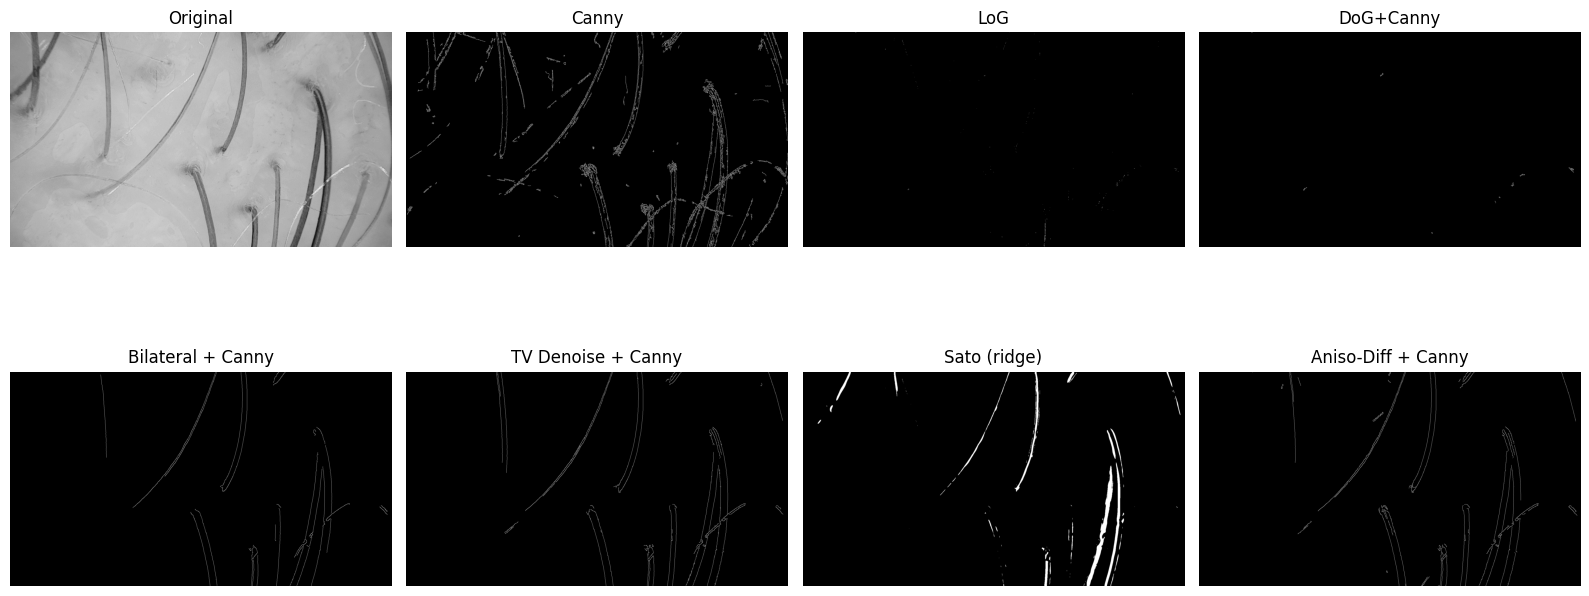

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, feature, restoration
from skimage.restoration import denoise_tv_chambolle
from scipy import ndimage
# For anisotropic diffusion (Perona–Malik) implementation from StackOverflow :contentReference[oaicite:1]{index=1}

img = cv2.imread('./łysienie/03945.jpg', cv2.IMREAD_GRAYSCALE)

edges_canny = cv2.Canny(img, threshold1=50, threshold2=150)


blur = cv2.GaussianBlur(img, (5, 5), sigmaX=1.0)
edges_log = cv2.Laplacian(blur, cv2.CV_64F)
edges_log = np.uint8(np.absolute(edges_log))
_, edges_log = cv2.threshold(edges_log, 20, 255, cv2.THRESH_BINARY)


g1 = cv2.GaussianBlur(img, (0,0), sigmaX=1.0)
g2 = cv2.GaussianBlur(img, (0,0), sigmaX=2.0)
dog = cv2.subtract(g1, g2)
edges_dog = cv2.Canny(dog, 30, 100)


bil = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
edges_bil_canny = cv2.Canny(bil, 50, 150)


tv = denoise_tv_chambolle(img/255.0, weight=0.1)
edges_tv_canny = cv2.Canny((tv*255).astype(np.uint8), 50, 150)


# pc = filters.sato(img)  # ridge detector via Hessian-based filter :contentReference[oaicite:2]{index=2}
pc = filters.sato(img / 255.0)  # normalize input

# Convert to binary edge map
# Threshold at a high percentile to isolate strong ridges (hair)
threshold_pc = np.percentile(pc, 98)  # or adjust to your dataset
edges_pc = (pc > threshold_pc).astype(np.uint8) * 255


def anisotropic_diffusion(img, niter=10, kappa=50, gamma=0.1):
    img = img.astype('float32')
    for _ in range(niter):
        nablaN = np.roll(img, -1, axis=0) - img
        nablaS = np.roll(img, 1, axis=0) - img
        nablaE = np.roll(img, -1, axis=1) - img
        nablaW = np.roll(img, 1, axis=1) - img

        cN = np.exp(-(nablaN / kappa) ** 2)
        cS = np.exp(-(nablaS / kappa) ** 2)
        cE = np.exp(-(nablaE / kappa) ** 2)
        cW = np.exp(-(nablaW / kappa) ** 2)

        img += gamma * (cN * nablaN + cS * nablaS + cE * nablaE + cW * nablaW)
    return img


ani = anisotropic_diffusion(img)
edges_ani_canny = cv2.Canny(ani.astype(np.uint8), 50, 150)


methods = [
    ('Original', img),
    ('Canny', edges_canny),
    ('LoG', edges_log),
    ('DoG+Canny', edges_dog),
    ('Bilateral + Canny', edges_bil_canny),
    ('TV Denoise + Canny', edges_tv_canny),
    ('Sato (ridge)', edges_pc),
    ('Aniso-Diff + Canny', edges_ani_canny),
]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for ax, (name, im) in zip(axes.flatten(), methods):
    ax.imshow(im, cmap='gray')
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()
plt.show()


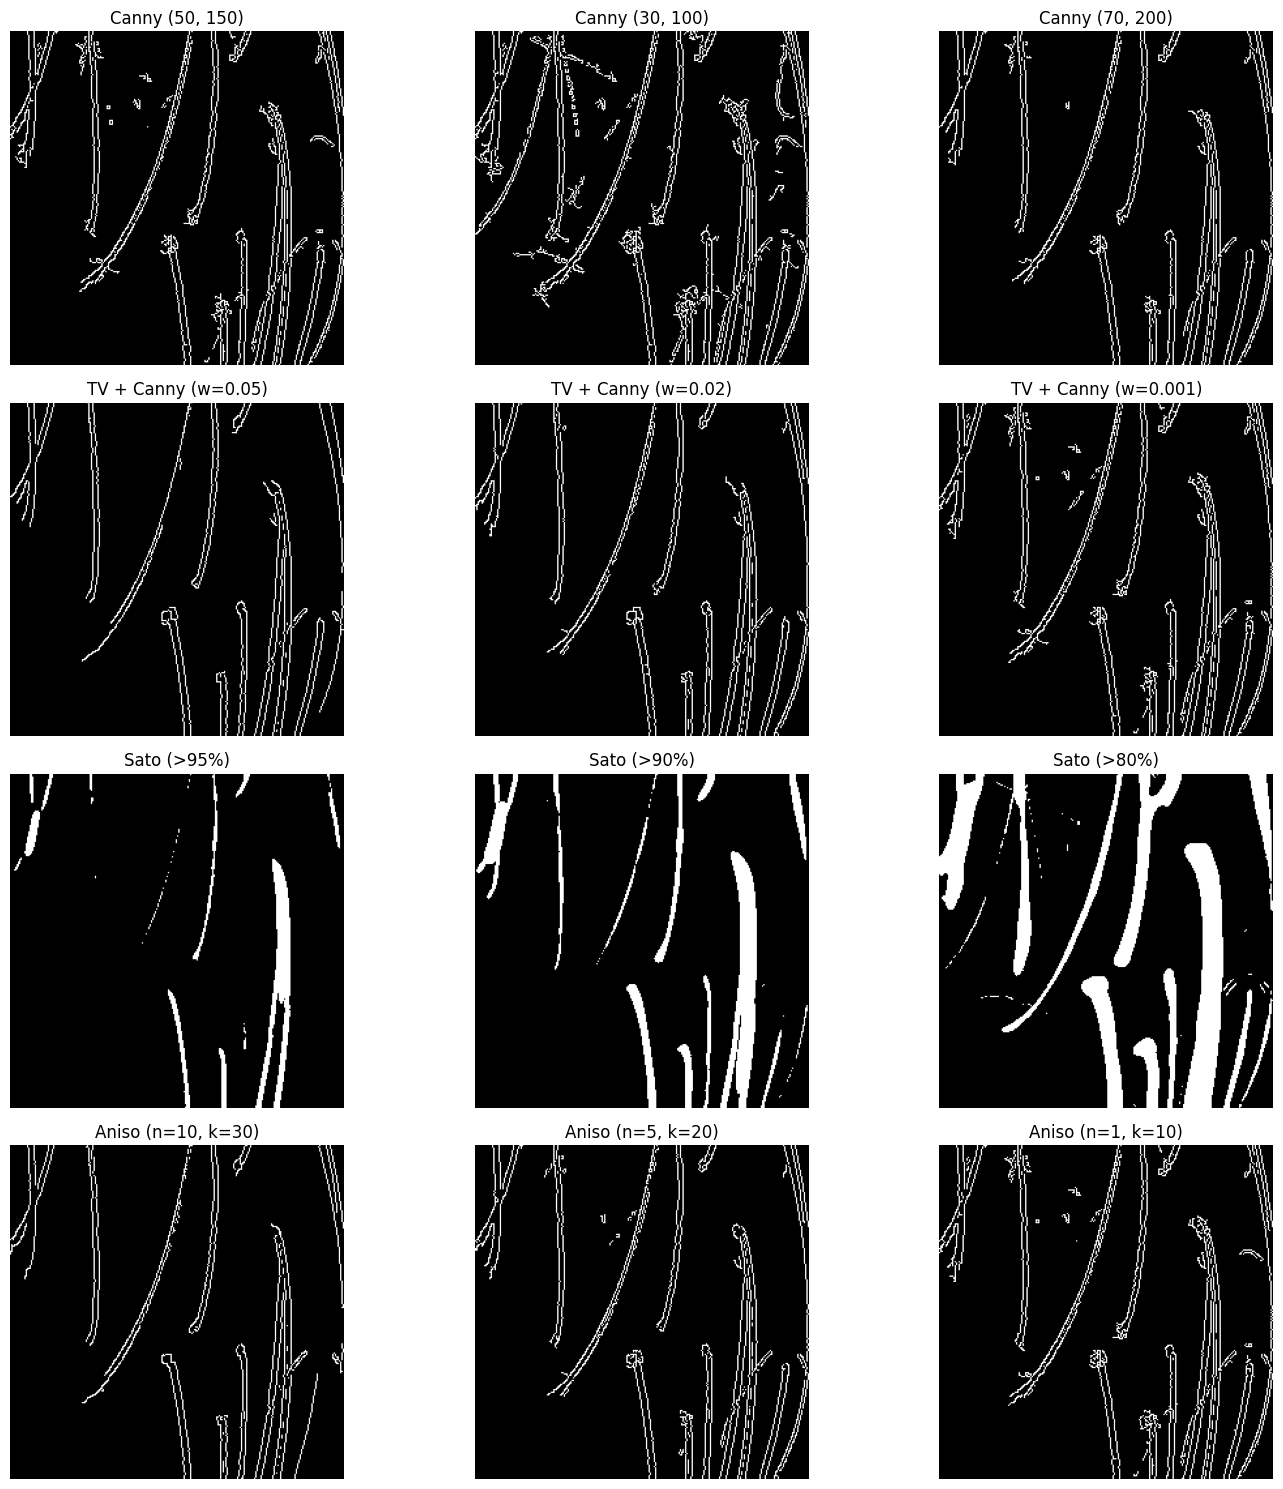

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage.restoration import denoise_tv_chambolle

# Load a sample image (replace with a real hair image in actual use)
img = cv2.imread('./łysienie/03945.jpg', cv2.IMREAD_GRAYSCALE)

# Resize for performance
img = cv2.resize(img, (256, 256))

def anisotropic_diffusion(img, niter=10, kappa=50, gamma=0.1):
    img = img.astype('float32')
    for _ in range(niter):
        nablaN = np.roll(img, -1, axis=0) - img
        nablaS = np.roll(img, 1, axis=0) - img
        nablaE = np.roll(img, -1, axis=1) - img
        nablaW = np.roll(img, 1, axis=1) - img

        cN = np.exp(-(nablaN / kappa) ** 2)
        cS = np.exp(-(nablaS / kappa) ** 2)
        cE = np.exp(-(nablaE / kappa) ** 2)
        cW = np.exp(-(nablaW / kappa) ** 2)

        img += gamma * (cN * nablaN + cS * nablaS + cE * nablaE + cW * nablaW)
    return img

# Prepare parameter combinations for methods
canny_params = [(50, 150), (30, 100), (70, 200)]
tv_weights = [0.05, 0.02, 0.001] #>0.1 - worse resutls
sato_percentiles = [95, 90, 80] #>95 - worse resutls
diffusion_settings = [(10, 30), (5, 20), (1, 10)] # 15, 50; 20, 70; - worse

# Results dictionary
results = []

# Try Canny with different thresholds
for t1, t2 in canny_params:
    edges = cv2.Canny(img, t1, t2)
    results.append((f'Canny ({t1}, {t2})', edges))

# Try TV denoising with Canny
for weight in tv_weights:
    tv = denoise_tv_chambolle(img / 255.0, weight=weight)
    edges = cv2.Canny((tv * 255).astype(np.uint8), 50, 150)
    results.append((f'TV + Canny (w={weight})', edges))

# Try Sato filter with different percentiles
pc = filters.sato(img / 255.0)
for perc in sato_percentiles:
    threshold = np.percentile(pc, perc)
    edges_pc = (pc > threshold).astype(np.uint8) * 255
    results.append((f'Sato (>{perc}%)', edges_pc))

# Try anisotropic diffusion with different settings
for niter, kappa in diffusion_settings:
    diffused = anisotropic_diffusion(img, niter=niter, kappa=kappa)
    edges = cv2.Canny(diffused.astype(np.uint8), 50, 150)
    results.append((f'Aniso (n={niter}, k={kappa})', edges))

# Plot results
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
for ax, (title, edge_img) in zip(axes.flatten(), results):
    ax.imshow(edge_img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


Another try from begginig

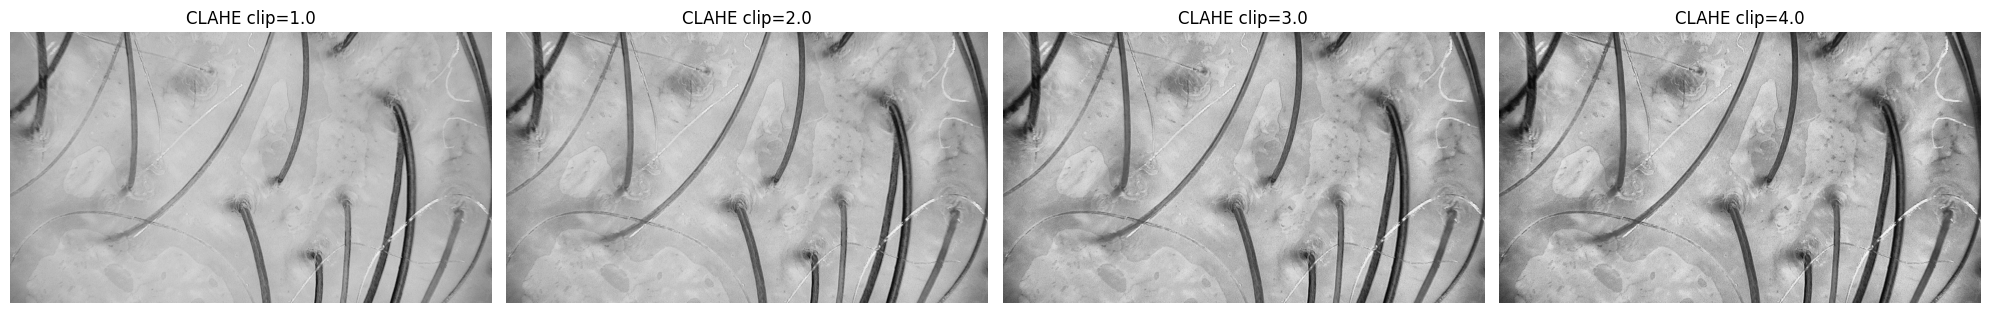

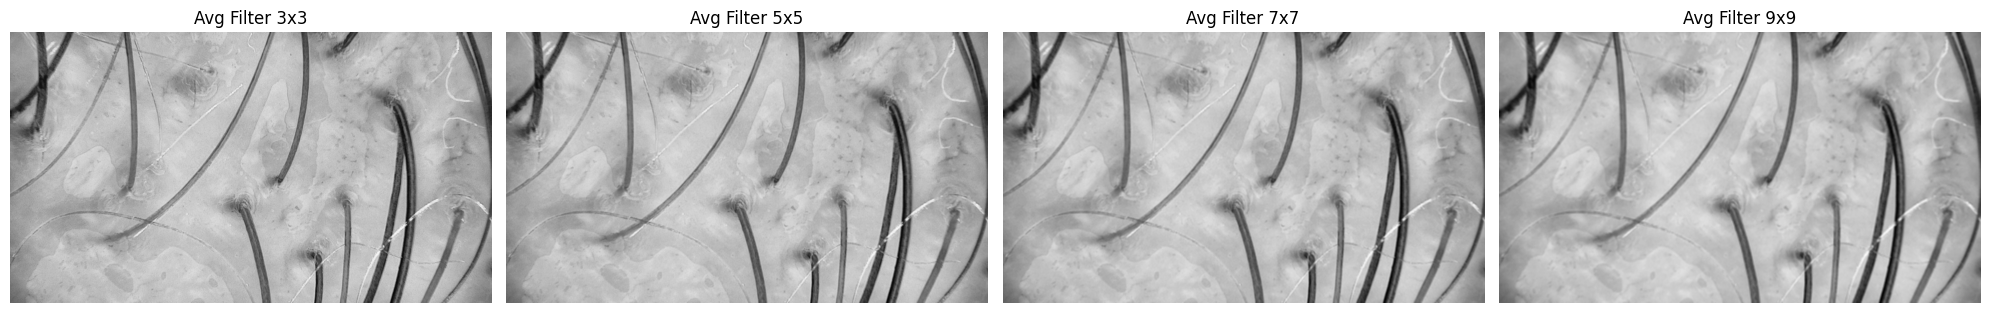

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.decomposition import PCA
import os

# Load a sample image (you can replace this with your own image later)
sample_image_path = './łysienie/03945.jpg'  # User should upload or replace this path
image = cv2.imread(sample_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert to LAB and apply PCA to collapse to grayscale
lab_image = color.rgb2lab(image_rgb)
lab_reshaped = lab_image.reshape((-1, 3))
pca = PCA(n_components=1)
pca_result = pca.fit_transform(lab_reshaped).reshape(lab_image.shape[:2])
pca_normalized = (pca_result - np.min(pca_result)) / (np.max(pca_result) - np.min(pca_result))

# Apply CLAHE with different clip limits
clahe_images = []
clip_limits = [1.0, 2.0, 3.0, 4.0]
for clip in clip_limits:
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8, 8))
    clahe_img = clahe.apply((pca_normalized * 255).astype(np.uint8))
    clahe_images.append((clip, clahe_img))

# Apply average filters of varying sizes
filtered_images = []
kernel_sizes = [3, 5, 7, 9]
for k in kernel_sizes:
    avg_img = cv2.blur(clahe_images[1][1], (k, k))  # using clipLimit=2.0 image as base
    filtered_images.append((k, avg_img))

# Show images with varying CLAHE clip limits
fig, axs = plt.subplots(1, len(clahe_images), figsize=(20, 5))
for ax, (clip, img) in zip(axs, clahe_images):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'CLAHE clip={clip}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Show images with different average filter sizes
fig, axs = plt.subplots(1, len(filtered_images), figsize=(20, 5))
for ax, (k, img) in zip(axs, filtered_images):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Avg Filter {k}x{k}')
    ax.axis('off')
plt.tight_layout()
plt.show()


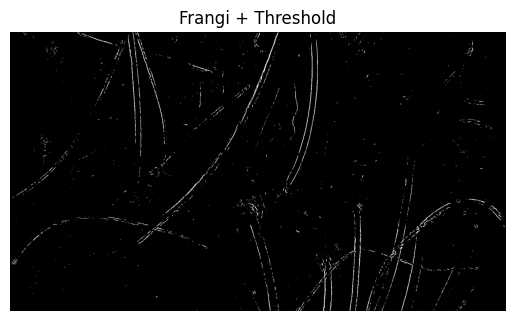

In [18]:
from skimage.filters import frangi
from skimage import img_as_float

# base_image = clahe_img
base_image = cv2.blur(clahe_img, (3, 3))

# Convert CLAHE result to float image for Frangi
float_img = img_as_float(base_image)

# Apply Frangi filter
frangi_result = frangi(float_img)

# Normalize result
frangi_norm = (frangi_result - frangi_result.min()) / (frangi_result.max() - frangi_result.min())

# Threshold (you can adjust threshold value)
binary = (frangi_norm > 0.1).astype(np.uint8) * 255

# Visualize
plt.imshow(binary, cmap='gray')
plt.title('Frangi + Threshold')
plt.axis('off')
plt.show()


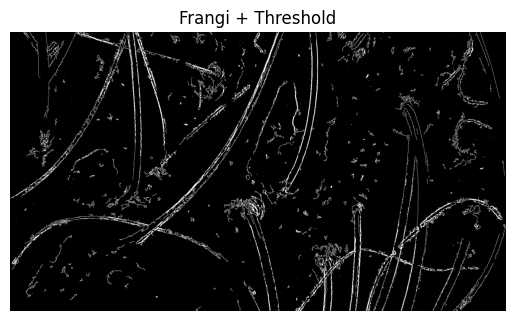

In [20]:
edges = cv2.Canny(base_image, 50, 150)
combined = np.logical_or(edges, frangi_norm > 0.1).astype(np.uint8) * 255

# Visualize
plt.imshow(combined, cmap='gray')
plt.title('Frangi + Threshold')
plt.axis('off')
plt.show()

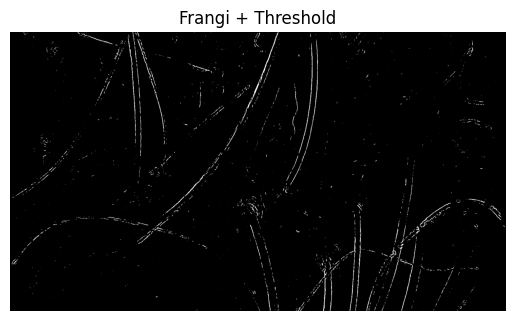

In [21]:
from skimage.morphology import closing, disk

closed = closing(binary, disk(1))  # or disk(2) for larger gaps

# Visualize
plt.imshow(closed, cmap='gray')
plt.title('Frangi + Threshold')
plt.axis('off')
plt.show()

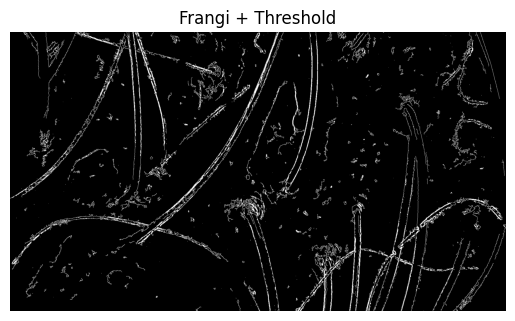

In [22]:
combined = np.logical_or(edges, closed).astype(np.uint8) * 255

# Visualize
plt.imshow(combined, cmap='gray')
plt.title('Frangi + Threshold')
plt.axis('off')
plt.show()

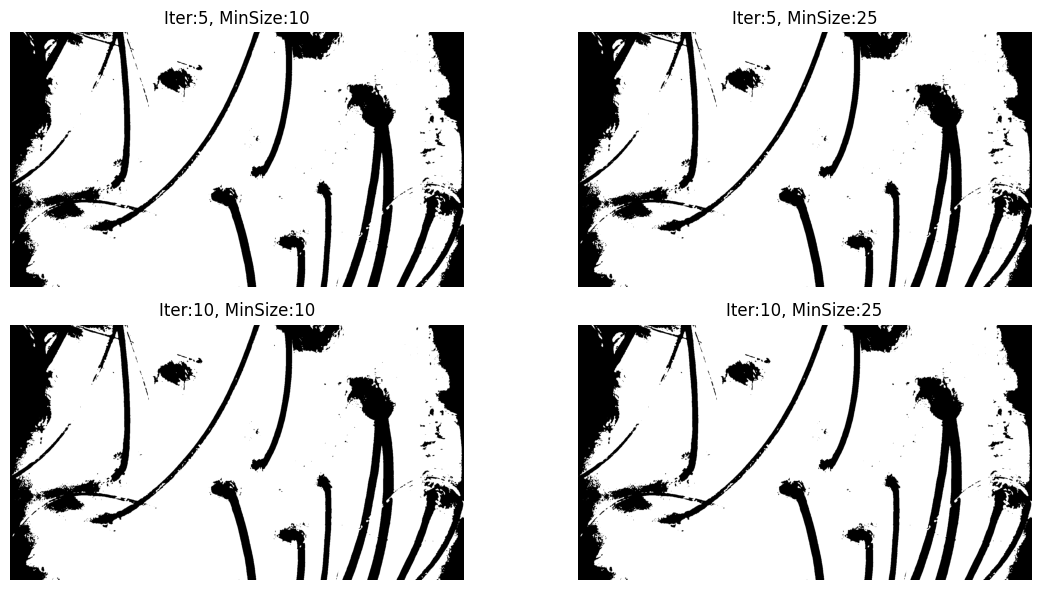

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import measure, morphology

def iterative_threshold(image, max_iter=5):
    T = np.mean(image)
    for _ in range(max_iter):
        foreground = image > T
        background = image <= T
        if foreground.sum() == 0 or background.sum() == 0:
            break
        m1 = np.mean(image[foreground])
        m2 = np.mean(image[background])
        T_new = (m1 + m2) / 2
        if abs(T - T_new) < 0.5:
            break
        T = T_new
    binary = (image > T).astype(np.uint8)
    return binary * 255

def remove_small_components(binary, min_size=25):
    label_image = measure.label(binary, connectivity=2)
    cleaned = np.zeros_like(binary)
    for region in measure.regionprops(label_image):
        if region.area >= min_size:
            coords = region.coords
            cleaned[tuple(coords.T)] = 255
    return cleaned

def blockwise_hough_mask(binary_img, block_size=50, hough_threshold=20, min_line_length=10, max_line_gap=4):
    mask = np.zeros_like(binary_img)
    height, width = binary_img.shape
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            block = binary_img[y:y+block_size, x:x+block_size]
            edges = cv2.Canny(block, 50, 150)
            lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=hough_threshold,
                                    minLineLength=min_line_length, maxLineGap=max_line_gap)
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    cv2.line(mask[y:y+block_size, x:x+block_size], (x1, y1), (x2, y2), 255, 1)
    return mask

# === Try different combinations ===
max_iters = [5, 10]
min_sizes = [10, 25]
hough_thresholds = [5, 10, 15]        # More sensitive to weak lines
min_lengths = [3, 5, 8]               # Catch short strands
gaps = [2, 5, 8]                      # Allow for fragmented line segments

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))  # Adjustable
# base_image = clahe.apply(gray_image) 
clahe_img = clahe.apply((pca_normalized * 255).astype(np.uint8))
base_image = cv2.blur(clahe_img, (5, 5))
# base_image = clahe_img

fig, axs = plt.subplots(len(max_iters), len(min_sizes), figsize=(12, 6))
for i, max_iter in enumerate(max_iters):
    for j, min_size in enumerate(min_sizes):
        binary = iterative_threshold(base_image, max_iter=max_iter)
        cleaned = remove_small_components(binary, min_size=min_size)
        hough_mask = blockwise_hough_mask(cleaned, hough_threshold=hough_thresholds[1],
                                          min_line_length=min_lengths[1], max_line_gap=gaps[1])
        axs[i, j].imshow(binary, cmap='gray')
        axs[i, j].set_title(f"Iter:{max_iter}, MinSize:{min_size}")
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()
